## Explore Data



In [1]:
import os

import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import requests
import fredapi
import yahoo_fin.stock_info as yahoo_fin

In [2]:
df = pd.read_csv('../data/nyt-index.csv', index_col=0, parse_dates=True)
df = df[~df.index.duplicated(keep='first')]

def resample_to_day(df):
    """Resample to daily frequency and fill missing values with expanding mean"""
    sma = df['index_value'].rolling(365, min_periods=1).mean()
    sma = sma.resample('D').ffill()
    
    df = df.resample('D').mean()
    df['index_value'] = df['index_value'].fillna(sma)
    df = df.fillna(0)
    return df

df = resample_to_day(df)
df.head()

,negative,neutral,positive,total,index_value,smoothed_index_value
date,,,,,,
1851-09-18,0.0,1.0,0.0,1.0,0.0,0.519565
1851-09-19,0.0,0.0,0.0,0.0,0.0,0.530431
1851-09-20,0.0,0.0,0.0,0.0,0.0,0.541349
1851-09-21,0.0,0.0,0.0,0.0,0.0,0.551777
1851-09-22,0.0,0.0,0.0,0.0,0.0,0.562085


In [3]:
# Get the total number of headlines per day
num_headlines = pd.DataFrame()
for f in os.listdir('../data/classified-nyt-data'):
    if f.endswith('.csv'):
        month = pd.read_csv(f'../data/classified-nyt-data/{f}', index_col=0, parse_dates=True)
        try:
            # count number of headlines per day
            month = month['headline'].groupby(month.index.date).count()
            num_headlines = pd.concat([num_headlines, month], axis=0)
        except Exception as e:
            print(f'Error in file {f}: {e}')
            continue

num_headlines = num_headlines[~num_headlines.index.duplicated(keep='first')]
num_headlines.index = pd.to_datetime(num_headlines.index)
num_headlines.index.name = 'date'
num_headlines = num_headlines.squeeze()
num_headlines = num_headlines.resample('D').mean()
num_headlines = num_headlines.fillna(0)
num_headlines.head()

Error in file 1978-09.csv: 'Index' object has no attribute 'date'
Error in file 1978-10.csv: 'Index' object has no attribute 'date'
Error in file 1995-11.csv: 'Index' object has no attribute 'date'


date
1851-09-18    10.0
1851-09-19    10.0
1851-09-20    10.0
1851-09-21     0.0
1851-09-22     4.0
Freq: D, Name: 0, dtype: float64

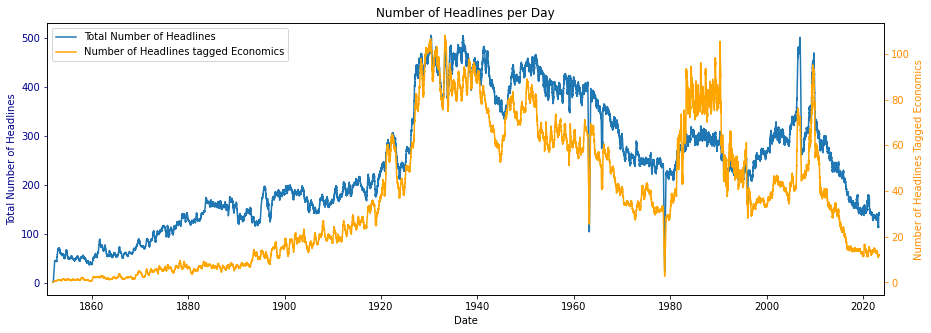

In [4]:
# plot NYT vs. FRBSF news sentiment index
fig, ax = plt.subplots(figsize=(15, 5))
num_headlines_sma = num_headlines.rolling(100).mean()
line1, = ax.plot(num_headlines_sma, label='Total Number of Headlines')
ax.tick_params(axis='y', colors='darkblue')
ax.set_xlabel('Date')
ax.set_ylabel('Total Number of Headlines', color='darkblue')

ax2 = ax.twinx()
num_economic_headlines_sma = df['total'].rolling(100).mean()
line2, = ax2.plot(num_economic_headlines_sma, label='Number of Headlines tagged Economics', color='orange')
ax2.tick_params(axis='y', colors='darkorange')
ax2.set_ylabel('Number of Headlines Tagged Economics', color='darkorange')

xmin = num_headlines_sma.index.min() - pd.Timedelta(days=365)
xmax = num_headlines_sma.index.max() + pd.Timedelta(days=365)
ax.set_xlim([xmin, xmax])

ax2.legend(handles=[line1, line2])
ax2.set_title('Number of Headlines per Day')
plt.show()

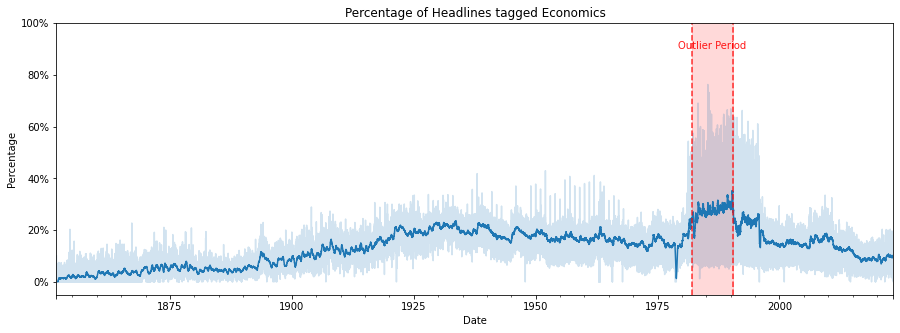

In [5]:
# Plot the percentage headlines tagged as `Economics` per day
econ_headlines_pct = df['total'] / num_headlines * 100
econ_headlines_pct = econ_headlines_pct.replace([np.inf, -np.inf], np.nan).fillna(0)

fig, ax = plt.subplots(figsize=(15, 5))
econ_headlines_pct.plot(ax=ax, alpha=0.2, color='#1f77b4')
econ_headlines_pct.rolling(100).mean().plot(ax=ax)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(x)))

# Shade red from 1982 to 1991
ax.axvspan(pd.to_datetime('1982-01-01'), pd.to_datetime('1990-06-01'), color='r', alpha=0.15)
ax.vlines(pd.to_datetime('1982-01-01'), -5, 100, color='red', linestyle='--', alpha=0.8)
ax.vlines(pd.to_datetime('1990-06-01'), -5, 100, color='red', linestyle='--', alpha=0.8)
ax.text(pd.to_datetime('1986-03-01'), 90, 'Outlier Period', color='red', alpha=0.9, 
        horizontalalignment='center')

plt.ylim(-5, 100)
plt.ylabel('Percentage')
plt.xlabel('Date')
plt.title('Percentage of Headlines tagged Economics')
plt.show()

In [6]:
# Get number of articles from the 'Financial Desk'/'Business' section of NYT
files = os.listdir('../data/classified-nyt-data')
start_idx = files.index('1980-01.csv')
files = files[start_idx:]

num_fin_articles = pd.DataFrame()
for f in files:
    if f.endswith('.csv'):
        data = pd.read_csv(f'../data/classified-nyt-data/{f}', index_col=0, parse_dates=True)
        try:
            finance_desk = (
                (data['topic'].str.contains('Financial Desk')) |
                (data['topic'].str.contains('Business'))
            )
            data = finance_desk.groupby(data.index.date).sum()
            num_fin_articles = pd.concat([num_fin_articles, data], axis=0)
        except Exception as e:
            print(f'Error in file {f}: {e}')
            continue

num_fin_articles.index = pd.to_datetime(num_fin_articles.index)
num_fin_articles = num_fin_articles.squeeze()
num_fin_articles.name = 'Num Financial Articles'
num_fin_articles = num_fin_articles.resample('D').mean()
num_fin_articles = num_fin_articles.fillna(0)

Error in file 1995-11.csv: 'Index' object has no attribute 'date'


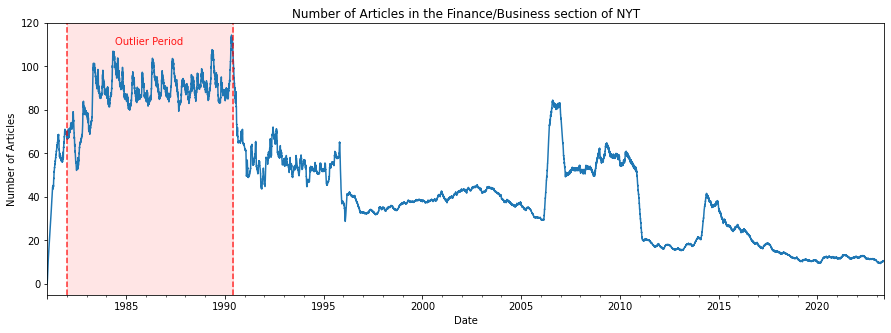

In [7]:
# Plot the number of articles from the Financial Desk section of NYT
ax = num_fin_articles.rolling(100).mean().loc['1981-01-01':].plot(
    figsize=(15, 5), 
    title='Number of Articles in the Finance/Business section of NYT',
    xlabel='Date',
    ylabel='Number of Articles'
)
ax.axvspan(pd.to_datetime('1982-01-01'), pd.to_datetime('1990-06-01'), color='r', alpha=0.1)
ax.vlines(pd.to_datetime('1982-01-01'), -5, 120, color='red', linestyle='--', alpha=0.8)
ax.vlines(pd.to_datetime('1990-06-01'), -5, 120, color='red', linestyle='--', alpha=0.8)
ax.text(pd.to_datetime('1986-03-01'), 110, 'Outlier Period', color='red', alpha=0.9, 
        horizontalalignment='center')
ax.set_ylim(-5, 120)
plt.show()

### Findings
- The percentage of 'Economic' news articles in the 1980s looks suspiciously high.
    - Upon further examination, it appears that NYT just published a lot more articles about finance in the 
    1980s than in other decades.
- Also, the percentage of 'Economic' news articles rises steadily until ~1920.
    - This is could be due to the fact that the topic classifier is trained on newer data, and the model is not able to accurately classify older articles.

## NYT News Sentiment Index

Next, we're going to construct and explore the smoothed and detrended NYT News sentiment index.

We'll compare the index against:
- S&P 500 bear markets
- [NBER recession dates](https://fred.stlouisfed.org/series/USRECD)
- [FRBSF Daily News Sentiment Index](https://www.frbsf.org/economic-research/indicators-data/daily-news-sentiment-index/files/news_sentiment_data.xlsx)

In [8]:
two_hundred_days = df['index_value'].ewm(span=100).mean()
ten_years = df['index_value'].rolling(365*10).mean()
index = two_hundred_days - ten_years + 0.5  # Detrended index
index.dropna(inplace=True)

In [9]:
def mark_bear_markets(df, thresh=0.2):
    turning_points = _get_turning_points(df, thresh=thresh)
    turning_points = turning_points.replace(0, np.nan)
    turning_points = turning_points.ffill()
    bear_markets = (turning_points == 1)
    bear_markets.name = f'SPX Bear Markets (-{thresh:.2%})'
    return bear_markets

    
def _get_turning_points(df, thresh=0.075):
    """Get the turning points for a given series where the pct change is
    greater than the threshold."""
    _highs = find_peaks(np.log10(df).values, prominence=(thresh / 2))[0]
    _lows = find_peaks(-np.log10(df).values, prominence=(thresh / 2))[0]

    turning_points = pd.Series(0, index=df.index)
    turning_points.iloc[_highs] = 1
    turning_points[_lows] = -1
    return turning_points


spx = yahoo_fin.get_data('^GSPC', start_date='1800-01-01')['adjclose']
spx = spx.resample('D').ffill()
bear_markets = mark_bear_markets(spx, thresh=0.2)
bear_markets.head()

1927-12-30    False
1927-12-31    False
1928-01-01    False
1928-01-02    False
1928-01-03    False
Freq: D, Name: SPX Bear Markets (-20.00%), dtype: bool

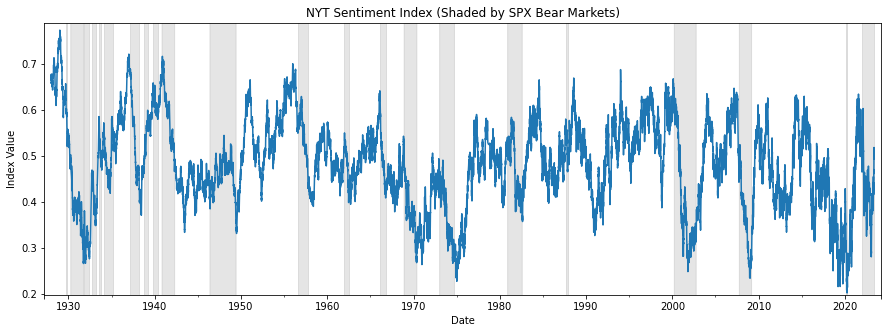

In [10]:
# Plot the index with S&P 500 bear markets shaded

def plot_index_with_shading(df, shading_df, start_date='1900-01-01', title=''):
    ax = df.loc[start_date:].plot(figsize=(15, 5), title=title)
    ymax = df.loc[start_date:].max()
    ymin = df.loc[start_date:].min()
    plt.ylim(ymin * 0.98, ymax * 1.02)
    
    num_days = (df.index.max() - df.index.min()).days
    timedelta = pd.Timedelta(days=num_days * 0.005)
    xmin = df.loc[start_date:].index.min() - timedelta
    xmax = df.loc[start_date:].index.max() + timedelta
    plt.xlim(xmin, xmax)

    ax.fill_between(shading_df.index, -10, 10, where=shading_df, color='grey', alpha=0.2)
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.show()

plot_index_with_shading(index, bear_markets, 
                        start_date=bear_markets.index.min(), 
                        title='NYT Sentiment Index (Shaded by SPX Bear Markets)')

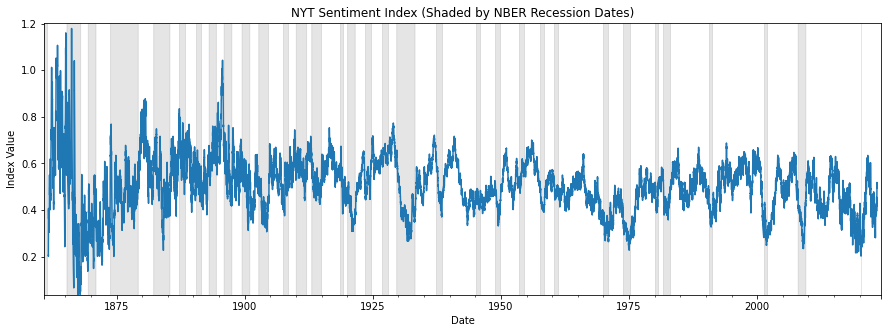

In [11]:
# Plot the index with NBER US recessions dates shaded
FRED_API_KEY = os.environ.get('FRED_API_KEY')
fred = fredapi.Fred(FRED_API_KEY)

recessions = fred.get_series('USRECD').resample('D').ffill()
plot_index_with_shading(index, recessions, 
                        start_date=recessions.index.min(), 
                        title='NYT Sentiment Index (Shaded by NBER Recession Dates)')

In [12]:
# Compare with the FRBSF Daily News Sentiment Index
url = 'https://www.frbsf.org/economic-research/indicators-data/'\
      'daily-news-sentiment-index/files/news_sentiment_data.xlsx'
req = requests.get(url)
frbsf_news_sentiment = pd.read_excel(req.content, engine='openpyxl', 
                                     sheet_name='Data', index_col='date').squeeze()

frbsf_news_sentiment.index = pd.to_datetime(frbsf_news_sentiment.index)
frbsf_news_sentiment.name = 'FRBSF Sentiment Index'
frbsf_news_sentiment.head()

date
1980-01-01   -0.038498
1980-01-02   -0.107768
1980-01-03   -0.091131
1980-01-05   -0.069345
1980-01-06   -0.091695
Name: FRBSF Sentiment Index, dtype: float64

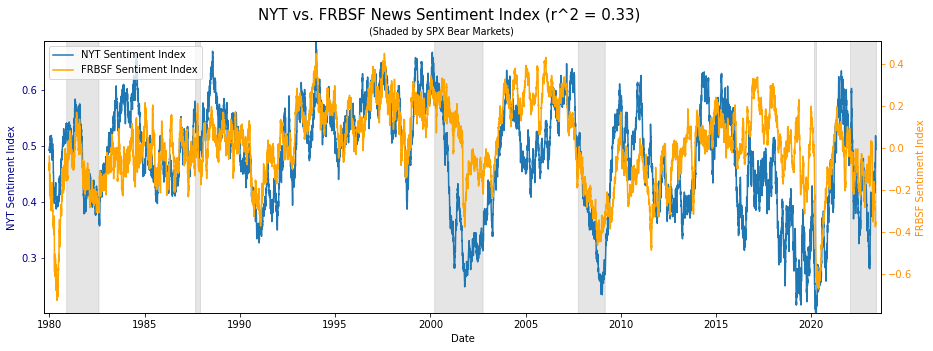

In [13]:
# plot NYT vs. FRBSF news sentiment index
fig, ax = plt.subplots(figsize=(15, 5))

line1, = ax.plot(index.loc['1980-01-01':], label='NYT Sentiment Index')
ax.tick_params(axis='y', colors='darkblue')
ax.set_ylabel('NYT Sentiment Index', color='darkblue')
ax.set_xlabel('Date')

ax.fill_between(bear_markets.index, 0, 1, where=bear_markets, color='grey', alpha=0.2)
ymin = index.loc['1980-01-01':].min()
ymax = index.loc['1980-01-01':].max()
ax.set_ylim([ymin, ymax])

ax2 = ax.twinx()
line2, = ax2.plot(frbsf_news_sentiment, label='FRBSF Sentiment Index', color='orange')
ax2.tick_params(axis='y', colors='darkorange')
ax2.set_ylabel('FRBSF Sentiment Index', color='darkorange')

xmin = index.loc['1980-01-01':].index.min() - pd.Timedelta(days=100)
xmax = index.loc['1980-01-01':].index.max() + pd.Timedelta(days=100)
ax.set_xlim([xmin, xmax])

ax2.legend(handles=[line1, line2])
corr = index.loc['1980-01-01':].corr(frbsf_news_sentiment) ** 2
plt.suptitle(f'NYT vs. FRBSF News Sentiment Index (r^2 = {corr:.2f})', size=15, y=0.975)
ax2.set_title('(Shaded by SPX Bear Markets)', size=9.5, x=0.475)
plt.show()

## Conclusions

- The index shows a